In [1]:
import os
import sys
sys.path.append('scripts')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import mcg
import h5py
import pandas as pd

import matplotlib_config as cfg
import fnmatch
from matplotlib import cm as cmpl
from matplotlib.colors import PowerNorm

from cmap import Colormap
import cmasher as cmr
import matplotlib.colors as mcolors 

# Setting the Colormap

In [2]:
cm = Colormap('crameri:lipari')
mpl_cm = cm.to_mpl().reversed()
cmap_colors = mpl_cm(np.linspace(0, 1, 256))
truncate_point = 0.1

truncated_colors = cmap_colors[int(256 * truncate_point):]
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

# Loading the data

In [3]:
step2us = 2e-9
burst = 1e5

grade_burst = 10

In [4]:
idx =['1', '2', '3', '4']
coordinate_basefolder = 'TPS_trajectories'
cagedata_basefolder = 'CageData'

coordinate_datafolders = [f'{coordinate_basefolder}/data_mu175_chain1_batch_{idx}' for idx in idx]
cages_datafolders = [f'{cagedata_basefolder}/cages_mu175_chain1_batch_{idx}' for idx in idx]

gro_folder = 'gro_files'

In [5]:
top_file = os.path.join(gro_folder, 'conf.gro')

# Building a dictionary that includes all data

This is done so that for each trajectory al additional information (like shooting point index, mcg, ... is directly linked)

In [6]:
def build_pd(run_folder_path):
    logfile_path = os.path.join(run_folder_path, 'log.txt')
    weights = np.load(os.path.join(run_folder_path, 'trajectory_weights.npy'))[1:]
    
    # Load the log file
    df = pd.read_fwf(
        logfile_path,
        header=0,
        widths=[21] * 7,
        strip=True
    )
    df.columns = df.columns.str.strip()
    
    # Initialize weights column with zeros
    df['Weights'] = 0.0
    
    # Get successful rows
    successful_indices = df[df['Successful'] == True].index
    
    # Sanity check
    assert len(successful_indices) == len(weights), "Mismatch between successful trajectories and weights"
    
    # Assign weights to successful trajectories
    for idx, weight in zip(successful_indices, weights):
        df.at[idx, 'Weights'] = weight

    return df

In [7]:

# Dictionary to store all run data
run_data = {}

for datafolder, cagefolder in zip(coordinate_datafolders, cages_datafolders):
    print(f'Loading {datafolder}')
    print(f'Loading {cagefolder}')
    run_data[datafolder] = {}
    
    for run_folder in os.listdir(datafolder):
        run_folder_path = os.path.join(datafolder, run_folder)
        
        # Skip non-directories and hidden folders
        if not os.path.isdir(run_folder_path) or run_folder.startswith('.'):
            continue
        
        # Initialize entry for this run
        run_data[datafolder][run_folder] = {
            'log': None,
            'index_succ': {},
            'trial_rej': {},
            'cages': {}
        }
        
        df = build_pd(run_folder_path)
        run_data[datafolder][run_folder]['log'] = df
        
        # Process successful trials
        for succ_file in os.listdir(run_folder_path):
            if succ_file.startswith('cv_') and not succ_file.endswith('_0.txt'):
                try:
                    trial_num = int(succ_file.split('_')[1].split('.')[0])
                    trial_path = os.path.join(run_folder_path, succ_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    cutoff_mask = mcg_values >= 300
                    B_cutoff = int(frames[np.argmax(cutoff_mask)] / burst) if np.any(cutoff_mask) else None

                    run_data[datafolder][run_folder]['index_succ'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values,
                        'B_cutoff': B_cutoff,
                        'file_path': os.path.join(run_folder_path, f'traj_{trial_num}.dcd')
                    }
                    try:
                        times, _, Cages_512, Cages_62512, Cages_64512, Cages_4151062, _ = np.loadtxt(f'{cagefolder}/{run_folder}/traj_{trial_num}_stride_10_grade.txt', skiprows = 1, unpack = True)
    
                        run_data[datafolder][run_folder]['cages'][trial_num] = {
                        'frames': times,
                        '512': Cages_512,
                        '62512': Cages_62512,
                        '64512': Cages_64512,
                        '4151062': Cages_4151062
                        }
                        cage_ratio = Cages_62512[-1] / Cages_4151062[-1]
                        run_data[datafolder][run_folder]['index_succ'][trial_num]['CageRatio'] = cage_ratio
                    except Exception as cage_error:
                        print(f"Cage data not available for trial {trial_num} in {run_folder}: {cage_error}")
                    

                except (ValueError, IndexError) as e:
                    print(f"Error processing {succ_file} in {run_folder}: {e}")
                    continue
        
        # Process rejected trials
        for rej_file in os.listdir(run_folder_path):
            if rej_file.startswith('rejected_cv_trial_') and not rej_file.endswith('_0.txt'):
                try:
                    trial_num = int(rej_file.split('_')[3].split('.')[0])
                    trial_path = os.path.join(run_folder_path, rej_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    run_data[datafolder][run_folder]['trial_rej'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values
                    }

                except (ValueError, IndexError) as e:
                    print(f"Error processing {rej_file} in {run_folder}: {e}")
                    continue
        


Loading TPS_trajectories/data_mu175_chain1_batch_1
Loading CageData/cages_mu175_chain1_batch_1
Loading TPS_trajectories/data_mu175_chain1_batch_2
Loading CageData/cages_mu175_chain1_batch_2
Loading TPS_trajectories/data_mu175_chain1_batch_3
Loading CageData/cages_mu175_chain1_batch_3
Loading TPS_trajectories/data_mu175_chain1_batch_4
Loading CageData/cages_mu175_chain1_batch_4


In [8]:
#n = len(successful_trajs)
#colors_mpl = cm.tab20(np.linspace(0, 1, n))
#c = 0

cage_ratios = []
cages_62512 = []
cages_4151062 = []

cage_ratios_halfway = []
cages_4_halfway = []
cages_5_halfway = []

cages_62512_traj = []


cage_ratio_traj = []
mcg_traj = []

all_Cages_62512 = []
all_Cages_4151062 = []

for dataset in run_data:
    for run in run_data[dataset]:
    
        #print(successful_df)
    
        for idx in run_data[dataset][run]['cages'].keys():

            df = run_data[dataset][run]['log']

            successful_df = df[df['Successful'] == True]
    
            #print(f'IDX:  {idx}')
    
            row = successful_df[successful_df['Index'] == idx]

            weight = int(row['Weights'].values[0])

            for iteration in range(weight):
        
                mcg_values = run_data[dataset][run]['index_succ'][idx]['mcg_values']
                mcg_values_cut = mcg_values[::grade_burst]
    
        
                cutoff_mask = mcg_values_cut >= 300
        
                frames = run_data[dataset][run]['cages'][idx]['frames']
        
            
                if np.any(cutoff_mask):
                    B_cutoff = np.argmax(cutoff_mask)
                else:
                    B_cutoff = len(frames) - 1  # or -1 or np.nan if you prefer a sentinel value
                
                mcg_values_cut = mcg_values_cut[: B_cutoff +1]
                
                Cages_512 = run_data[dataset][run]['cages'][idx]['512']
                Cages_62512 = run_data[dataset][run]['cages'][idx]['62512']
                Cages_64512 = run_data[dataset][run]['cages'][idx]['64512']
                Cages_4151062 = run_data[dataset][run]['cages'][idx]['4151062']
    
    
                all_Cages_62512.append(Cages_62512)
                all_Cages_4151062.append(Cages_4151062)
                
                frames_cutoff = frames[: B_cutoff +1]
        
                mcg_traj.append(mcg_values_cut)
            
        
                cage_ratio = Cages_62512[-1] / Cages_4151062[-1]
                cage_ratio_frames = Cages_62512 - Cages_4151062
    
                total_cage_count_frames = Cages_512 + Cages_62512 + Cages_64512 + Cages_4151062
    
                if cage_ratio < 1:
                    structure = 'amorphous'
                if cage_ratio >= 1:
                    structure = 'crystalline'
        
                run_data[dataset][run]['index_succ'][idx]['CageRatio'] = cage_ratio
                run_data[dataset][run]['index_succ'][idx]['CageRatioFrames'] = cage_ratio_frames
                run_data[dataset][run]['index_succ'][idx]['Structure'] = structure
                run_data[dataset][run]['index_succ'][idx]['CageCount'] = total_cage_count_frames
                
                cage_ratio_traj.append( Cages_62512 / Cages_4151062 )
                #print(cage_ratio_traj)
                
        
                N = len(frames)
        
                cage_ratios.append(cage_ratio)
                cages_62512.append(Cages_62512[-1])
                cages_4151062.append(Cages_4151062[-1])
        
                cages_62512_traj.append(Cages_62512)
        
                cage_ratios_halfway.append(Cages_62512[N // 2] / Cages_4151062[N // 2])
                cages_4_halfway.append(Cages_4151062[N // 2])
                cages_5_halfway.append(Cages_62512[N // 2])
            
    
            #plt.plot(frames_cutoff * step2us, Cages_512, label = '512', c=cfg.colors['lightblue'])
            #plt.plot(frames_cutoff * step2us, Cages_62512, label = '62512', c=cfg.colors['purple'])
            #plt.plot(frames_cutoff * step2us, Cages_64512, label = '64512', c=cfg.colors['red'])
            #plt.plot(frames_cutoff * step2us, Cages_4151062, label = '4151062', c=cfg.colors['lightgreen'])
            #plt.scatter(sp_idx * step2us, sp_cv, zorder = 100, c = 'black')
            #c += 1
            #plt.show()
    
    #plt.legend()
    #plt.xlabel('time ($\mu s$)')
    #plt.ylabel('Cage Number')
    
    #plt.show()

/scratch_local/ipykernel_1128260/1469027696.py:86: RuntimeWarning: divide by zero encountered in divide
  cage_ratio_traj.append( Cages_62512 / Cages_4151062 )
/scratch_local/ipykernel_1128260/1469027696.py:86: RuntimeWarning: invalid value encountered in divide
  cage_ratio_traj.append( Cages_62512 / Cages_4151062 )
/scratch_local/ipykernel_1128260/1469027696.py:98: RuntimeWarning: divide by zero encountered in scalar divide
  cage_ratios_halfway.append(Cages_62512[N // 2] / Cages_4151062[N // 2])


## ONLY ENDPOINTS

In [9]:
cm_name = 'crameri:acton'
cm_name = 'crameri:lipari'
cm_name = 'seaborn:rocket'
#cm_name = 'colorbrewer:YlGnBu_9'


cm = Colormap(f'{cm_name}')
mpl_cm = cm.to_mpl().reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 256))
truncate_point = 0.2

truncated_colors = cmap_colors[int(256 * truncate_point):]
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

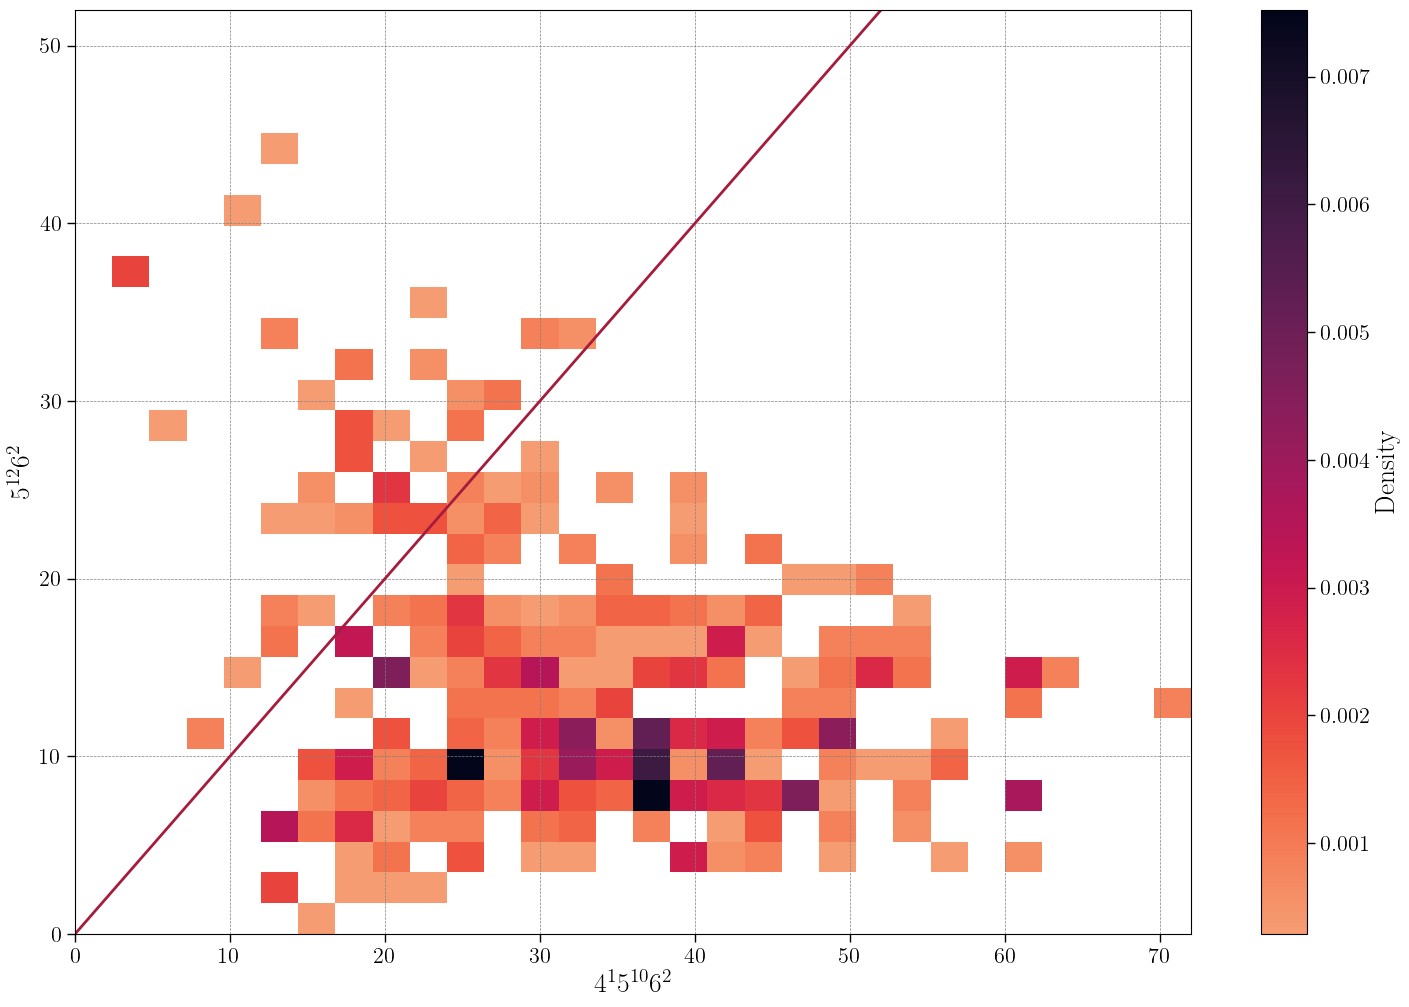

In [10]:
plt.figure(figsize=(18, 12))
x = np.arange(100)
counts, xedges, yedges = np.histogram2d(
    cages_4151062,
    cages_62512,
    bins=30,
    range=[[0, 72], [0, 52]],
    density = True
)

masked_counts = np.ma.masked_where(counts == 0, counts)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")

plt.pcolormesh(X, Y, masked_counts, cmap=cmap)
plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Density')
plt.xlabel(r'$4^15^{10}6^2$')
plt.ylabel(r'$5^{12}6^2$')
plt.xlim(0, 72)
plt.ylim(0, 52)
#plt.savefig('../figures/CageHistograms/structure_analysis_histogram.png')
plt.show()


In [11]:
np.savez(
    '../Histogram_Comparison/data/1wS_histogram_data_endpoints.npz',
    counts=counts,
    xedges=xedges,
    yedges=yedges
)

## SAVING LISTS OF AMORPHOUS/CRYSTALLINE TRAJECTORIES

In [12]:
crystalline_trajectories = []
amorphous_trajectories = []


for dataset in run_data:
    for run in run_data[dataset]:
        #print(dataset)
    
        #print(successful_df)
    
        for idx in run_data[dataset][run]['index_succ'].keys():
            structure = run_data[dataset][run]['index_succ'][idx]['Structure']
            #print(structure)
            if structure == 'crystalline':
                traj_path = run_data[dataset][run]['index_succ'][idx]['file_path']
                crystalline_trajectories.append(traj_path)

            else:
                traj_path = run_data[dataset][run]['index_succ'][idx]['file_path']
                amorphous_trajectories.append(traj_path)
        

In [13]:
np.savetxt('CriticalNucleus/CrystallineTrajectoriesList.txt', crystalline_trajectories, fmt='%s')
np.savetxt('CriticalNucleus/AmorphousTrajectoriesList.txt', amorphous_trajectories, fmt='%s')


## FULL TRAJECTORIES

In [14]:
all_Cages_4151062_flattened = [item for sublist in all_Cages_4151062 for item in sublist]
all_Cages_62512_flattened = [item for sublist in all_Cages_62512 for item in sublist]


In [15]:
cm_name = 'crameri:acton'
cm_name = 'seaborn:rocket'


cm = Colormap(f'{cm_name}')
mpl_cm = cm.to_mpl().reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 256))
truncate_point = 0.1

truncated_colors = cmap_colors[int(256 * truncate_point):]
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

In [16]:
x = np.arange(100)

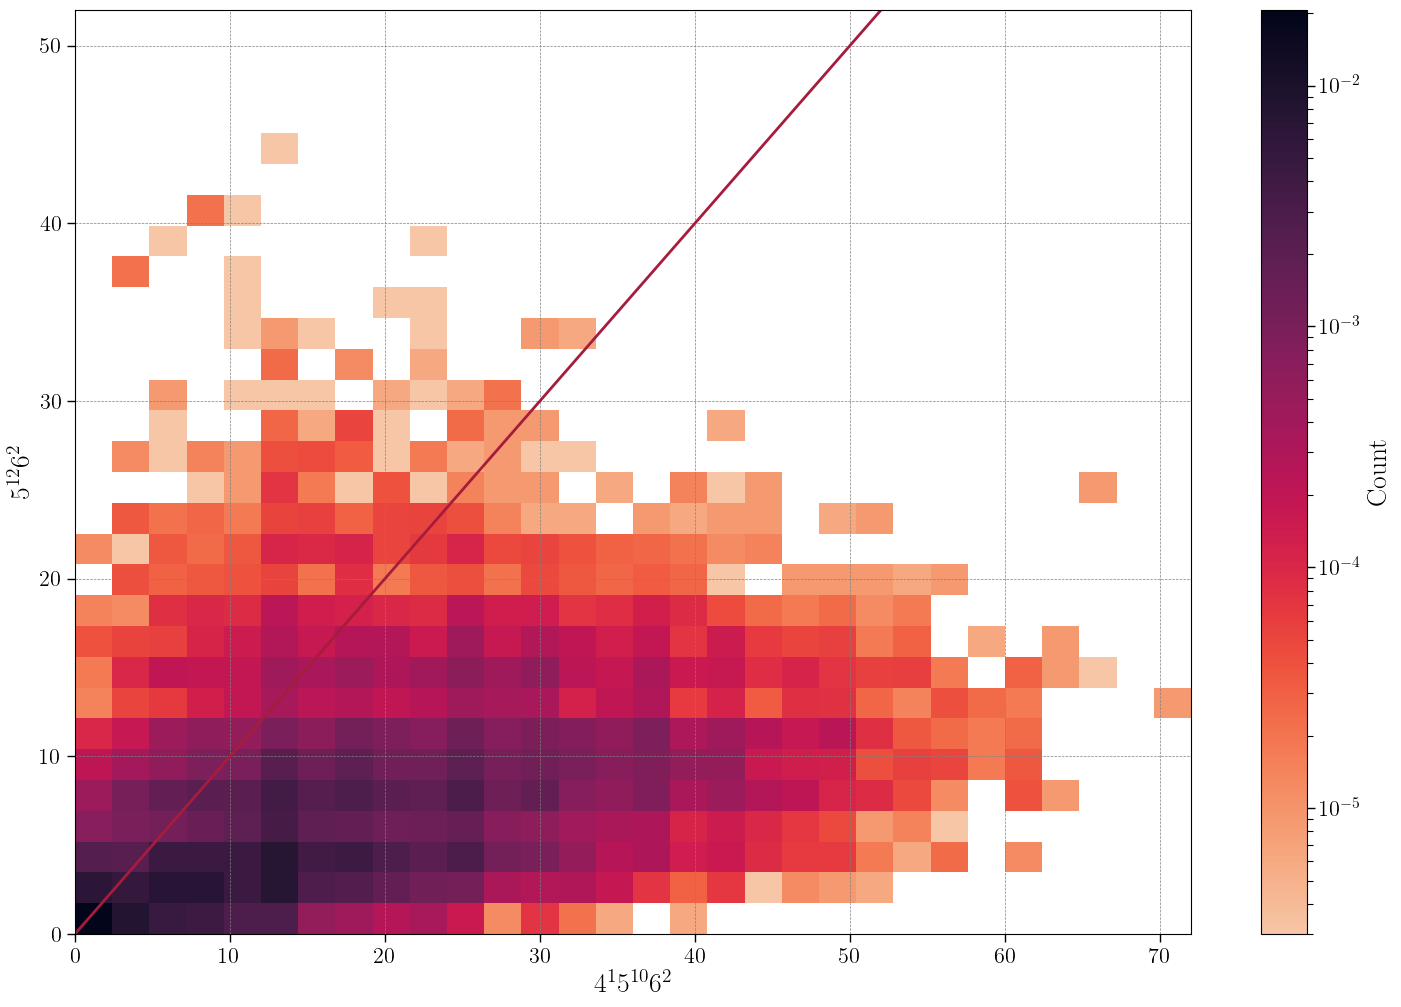

In [17]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(18, 12))

counts, xedges, yedges = np.histogram2d(
    all_Cages_4151062_flattened,
    all_Cages_62512_flattened,
    bins=30,
    range=[[0, 72], [0, 52]],
    density = True
)

masked_counts = np.ma.masked_where(counts == 0, counts)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")

plt.pcolormesh(X, Y, masked_counts, cmap=cmap, norm=LogNorm())
plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Count')
plt.xlabel(r'$4^15^{10}6^2$')
plt.ylabel(r'$5^{12}6^2$')
plt.xlim(0, 72)
plt.ylim(0, 52)
#plt.savefig('../figures/CageHistograms/structure_analysis_histogram_full_traj.png')
plt.show()


In [18]:
np.savez(
    '../Histogram_Comparison/data/1wS_histogram_data.npz',
    counts=counts,
    xedges=xedges,
    yedges=yedges
)

In [19]:
CutoffCageNumber = 5
mcg_all_frames = []
mcg_all_frames_cutoff = []
cr_all_frames = []
cr_all_frames_cutoff = []
CageCount_frames = []

for run_idx in range(12):
    CR_list = []
    run = f'run_{run_idx}'
    for dataset in run_data:
        #print(dataset)
        for idx in run_data[dataset][run]['index_succ'].keys():
            
            CageCount = run_data[dataset][run]['index_succ'][idx]['CageCount']
            
            count_62512 = run_data[dataset][run]['cages'][idx]['62512']
            count_4151062 = run_data[dataset][run]['cages'][idx]['4151062']

            mask_62512 = count_62512 >= CutoffCageNumber
            mask_4151062 = count_4151062 >= CutoffCageNumber

            combined_mask = mask_62512 & mask_4151062

            
            CR = run_data[dataset][run]['index_succ'][idx]['CageRatioFrames']

            #frames = run_data[dataset][run]['index_succ'][idx]['frames']
            mcg_values = run_data[dataset][run]['index_succ'][idx]['mcg_values'][::grade_burst]

            #print(CR)
            #print(mcg_values)



            if len(CR) != len(mcg_values):
                print(dataset, run, idx)
                #print(f'Must have same length! CR {len(CR)} MCG {len(mcg_values)} {CR} {mcg_values}  {dataset} {run} {idx}')
                #raise IndexError(f'Must have same length! CR {len(CR)} MCG {len(mcg_values)} {CR} {mcg_values}  {dataset} {run} {idx}')
                continue
                
            else: 
                CR_withcutoff = CR[combined_mask]
                mcg_withcutoff = mcg_values[combined_mask]
                
                cr_all_frames.extend(CR)
                cr_all_frames_cutoff.extend(CR_withcutoff)
                mcg_all_frames.extend(mcg_values)
                mcg_all_frames_cutoff.extend(mcg_withcutoff)
                CageCount_frames.extend(CageCount)


cr_mcg = np.vstack((mcg_all_frames_cutoff, cr_all_frames_cutoff))
mask = ~(np.isnan(cr_mcg[1, :]) | np.isinf(cr_mcg[1, :]))
clean_cr_mcg = cr_mcg[:, mask]

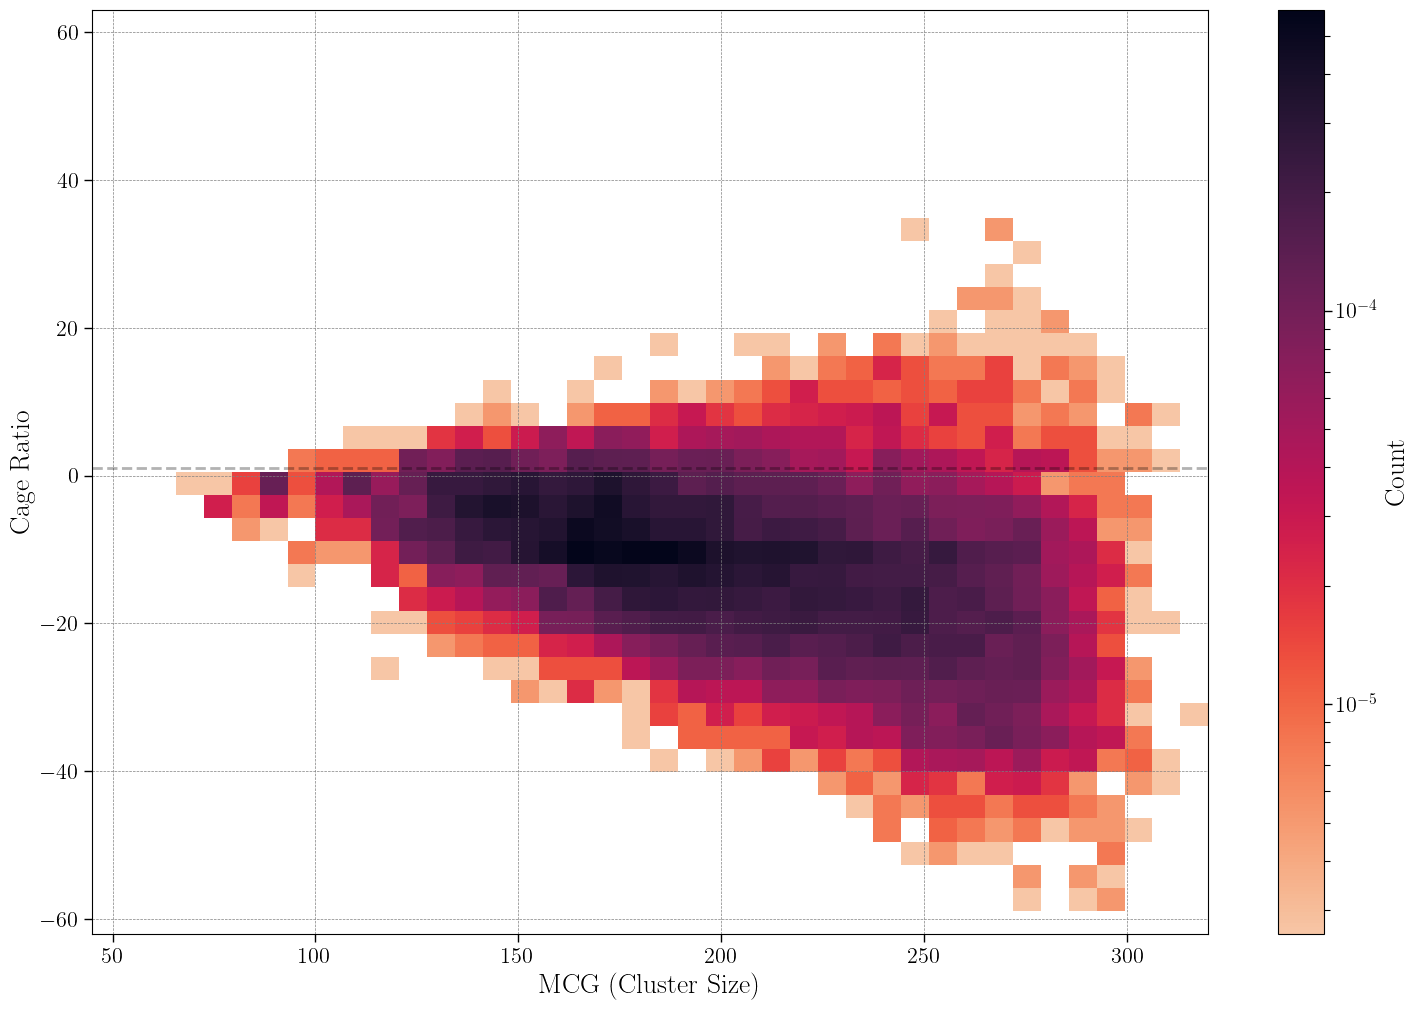

In [20]:
plt.figure(figsize=(18, 12))

counts, xedges, yedges = np.histogram2d(
    clean_cr_mcg[0, :],
    clean_cr_mcg[1, :],
    bins=40,
    density = True,
    range=[[45, 320], [-62, 63]]
)

masked_counts = np.ma.masked_where(counts == 0, counts)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")

plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)

plt.pcolormesh(X, Y, masked_counts, cmap=cmap, norm=LogNorm())
#plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Count')
plt.xlabel(r'MCG (Cluster Size)')
plt.ylabel(r'Cage Ratio')
#plt.xlim(0, 60)
#plt.ylim(0, 35)
#plt.savefig('../figures/CageHistograms/cr_vs_mcg.png')
plt.show()

np.savez(
    '../Histogram_Comparison/data/1wS_cr_vs_mcg.npz',
    counts=counts,
    xedges=xedges,
    yedges=yedges
)

In [21]:
counts_CageCount, xedges, yedges = np.histogram2d(
    mcg_all_frames,
    CageCount_frames,
    bins=40
    #range=[[0, 60], [0, 35]]
)

In [22]:
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
xcenters = 0.5 * (xedges[:-1] + xedges[1:])

weighted_cage_sum = np.sum(counts_CageCount * ycenters[np.newaxis, :], axis=1)

total_counts = np.sum(counts_CageCount, axis=1)

with np.errstate(divide='ignore', invalid='ignore'): #safe division
    avg_cage_per_mcg = np.divide(weighted_cage_sum, total_counts)
    avg_cage_per_mcg = np.nan_to_num(avg_cage_per_mcg) 

In [23]:
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 40,
    'axes.titlesize': 18,
    'xtick.labelsize': 40,
    'ytick.labelsize': 40,
    'legend.fontsize': 35,
    'legend.frameon': False,
    'axes.grid': True
})

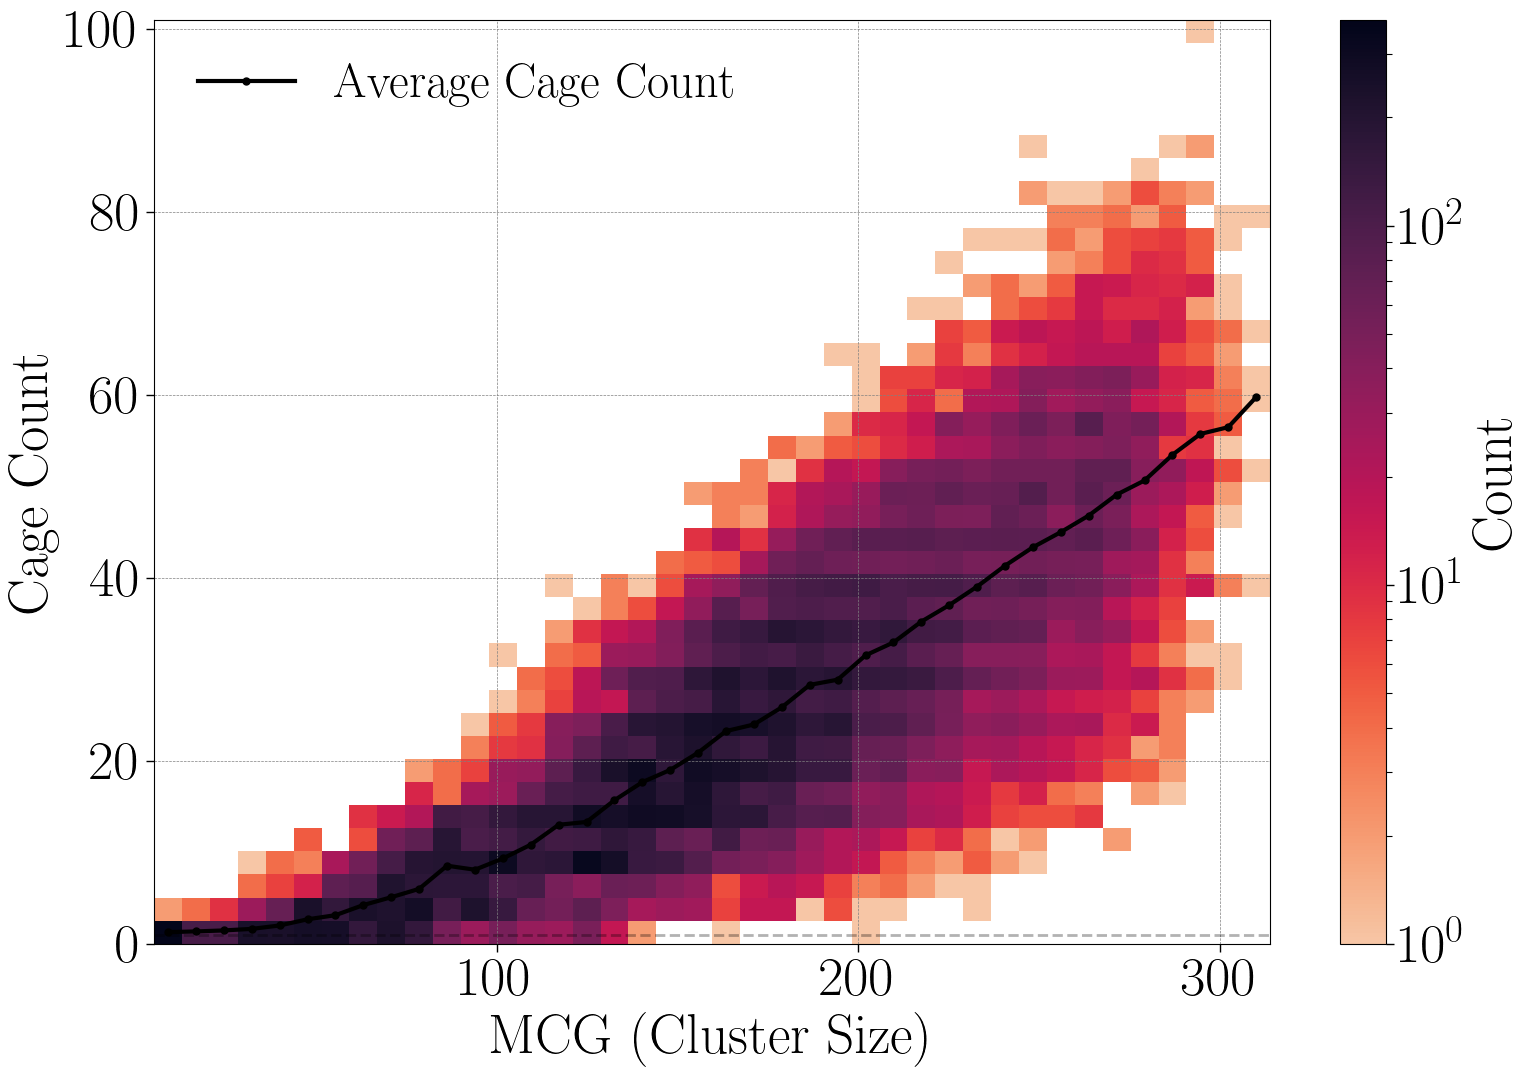

In [24]:
plt.figure(figsize=(18, 12))

masked_counts = np.ma.masked_where(counts_CageCount == 0, counts_CageCount)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")

plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)

plt.pcolormesh(X, Y, masked_counts, cmap=cmap, norm=LogNorm())
plt.plot(xcenters, avg_cage_per_mcg, c = 'black', label = 'Average Cage Count', marker = 'o', ms = 5, lw = 3)


#plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Count')
plt.xlabel(r'MCG (Cluster Size)')
plt.ylabel(r'Cage Count')
#plt.xlim(0, 60)
#plt.ylim(0, 35)
#plt.savefig('figures/CageHistograms/cage_count.png')
plt.legend(loc = 'upper left')
plt.show()